In [12]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

# NLTK/NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk import FreqDist, word_tokenize
import string, re
import urllib
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.collocations import *
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import KeyedVectors

# Classifiers 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import scikitplot as skplt

#Sampling
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import sklearn.decomposition as decomposition

#Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

import csv

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve



In [13]:
import pickle

In [14]:
%run custom_functions_test.ipynb

In [15]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [16]:
df.head()

,id,label,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,29727,0,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre engrus ...,"[sad, to, see, the, scenes, of, hooligans, pre...","[sad, to, see, the, scene, of, hooligan, pre, ...","[sad, to, see, the, scene, of, hooligan, pre, ...",sad to see the scenes of hooligans pre engrus ...,sad to see the scenes of hooligans pre engrus ...
1,14466,0,#gooddyeyoung #yoyoyo !! super happy to be ap...,#gooddyeyoung #yoyoyo super happy to be apa of...,gooddyeyoung yoyoyo super happy to be apa of t...,"[gooddyeyoung, yoyoyo, super, happy, to, be, a...","[gooddyeyoung, yoyoyo, super, happi, to, be, a...","[gooddyeyoung, yoyoyo, super, happy, to, be, a...",gooddyeyoung yoyoyo super happy to be apa of t...,gooddyeyoung yoyoyo super happy to be apa of t...
2,18194,0,queen evil's bihdayð#lnic #lnicjustanevilbd...,queen evil s bihday #lnic #lnicjustanevilbday ...,queen evil s bihday lnic lnicjustanevilbday bi...,"[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...",queen evil s bihday lnic lnicjustanevilbday bi...,queen evil s bihday lnic lnicjustanevilbday bi...
3,18283,1,@user you might be a libtard if... #libtard #...,you might be a libtard if #libtard #sjw #liber...,you might be a libtard if libtard sjw liberal ...,"[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...",you might be a libtard if libtard sjw liberal ...,you might be a libtard if libtard sjw liberal ...
4,25845,0,what are your goals? find out here... #smile...,what are your goals find out here #smile,what are your goals find out here smile,"[what, are, your, goals, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]",what are your goals find out here smile,what are your goals find out here smil


## Train / Val / Test Split

In [17]:
X = df.drop(['label'], axis = 1)

In [18]:
y = df['label']

In [77]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [78]:
#splitting "model" into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify = y_model, test_size=0.20, random_state=123)

## Comparing Vectorization and Method Performance

In [21]:
count_vect = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer(min_df=.001)
tfidf_ngram = TfidfVectorizer(ngram_range=(1,2), min_df=.001)
tfidf_ngram2 = TfidfVectorizer(ngram_range=(2,3),min_df=.001)

logreg = LogisticRegression(random_state=10)
rfc = RandomForestClassifier(random_state=10)
nb = MultinomialNB()
svc = SVC(random_state=10)

vectorization_list = [('COUNT_VECTORIZER', count_vect),
                      ('TFIDF_VECTORIZER', tfidf_vectorizer),
                      ('TFIDF_NGRAM_1_2', tfidf_ngram),
                      ('TFIDF_NGRAM_2_3', tfidf_ngram2)]



## Logistic Regression

#### Grid Searching with Upsampled Training Data

In [23]:
np.random.seed(10)

logreg = LogisticRegression(random_state= 10)

c_space = np.linspace (.1, 10, 100)
# c_space = np.logspace(-5, 8, 15)

parameters = {'C': c_space, 
          'penalty': ['l1', 'l2']}

scores = ['accuracy','recall','precision','f1']

lr_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [41]:
lr_gs_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, lr_gs, count_vect, sampling= 'upsample')

In [42]:
lr_gs_model.best_params_

{'C': 8.4, 'penalty': 'l1'}

In [43]:
lr_metrics_dict

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.65,
 'Validation Recall': 0.66,
 'Validation F1': 0.65}

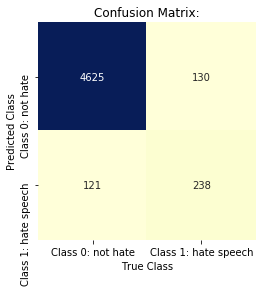

In [44]:
#before threshhold adjustment

seaborn_confusion_matrix(y_val, lr_y_val_pred)

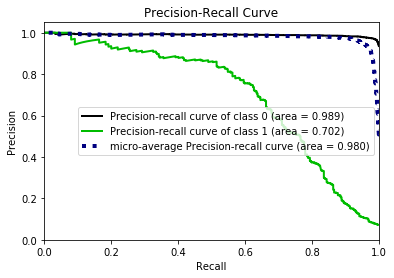

In [45]:
skplt.metrics.plot_precision_recall_curve(y_val, lr_y_val_prob)

Adjusted Accuracy: 0.9587407117716074
Adjusted Precision: 0.7466666666666667
Adjusted Recall: 0.6239554317548747
Adjusted F1 Score: 0.6798179059180577




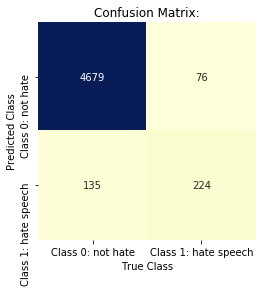

In [48]:
#with threshold adjustment
lr_pred_adj, cm = adjust_threshold_and_score(y_val, lr_y_val_prob, .2)

## Final Logistic Regression Model

In [97]:
lr_final_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, 
                y_test, LogisticRegression(C = 8.4, penalty = 'l1', random_state = 10), count_vect, sampling= 'upsample')

In [98]:
lr_metrics_dict

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.68,
 'Validation Recall': 0.67,
 'Validation F1': 0.67}

In [99]:
print_classification_report(y_test, lr_y_val_pred)

              precision    recall  f1-score   support

    not hate       0.97      0.98      0.98      5945
 hate speech       0.68      0.67      0.67       448

    accuracy                           0.95      6393
   macro avg       0.83      0.82      0.82      6393
weighted avg       0.95      0.95      0.95      6393



Adjusted Accuracy: 0.9583919912404192
Adjusted Precision: 0.7433155080213903
Adjusted Recall: 0.6205357142857143
Adjusted F1 Score: 0.6763990267639903




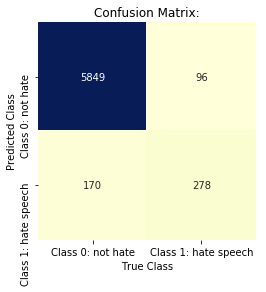

In [100]:
lr_y_test_adj, cm = adjust_threshold_and_score(y_test, lr_y_val_prob, .2)

In [107]:
# lr_misclassified_df = lr_pred_df[lr_pred_df['predicted class'] != lr_pred_df['actual class']]
# lr_misclassified_df.head()

In [108]:
# lr_pred_df['actual class'] = pd.Series(lr_pred_df['actual class'])

In [109]:
# lr_pred_df['actual class'].values

## Exploring Misclassified Tweets in Test Set

In [ ]:
lr_pred_df['adjusted class'] = lr_y_test_adj

In [66]:
lr_misclassified2_df.shape

(246, 5)

In [145]:
lr_misclassified2_df = lr_misclassified_df[lr_misclassified_df['adjusted class'] != lr_misclassified_df['actual class']]
lr_misclassified2_df.head(10)

,prob 0,prob 1,predicted class,actual class,adjusted class
6161,0.99,0.01,0,1,0
30958,0.99,0.01,0,1,0
27842,1.00,0.00,0,1,0
3139,0.04,0.96,1,0,1
16925,0.63,0.37,0,1,0
13437,1.00,0.00,0,1,0
18929,0.07,0.93,1,0,1
5583,0.00,1.00,1,0,1
22916,1.00,0.00,0,1,0
9349,1.00,0.00,0,1,0


## Actual 1, Classified 0

In [140]:
df['tidy_tweet'][6161]

'i decided to become a #feminist beginning if any feminists are reading plz help to find educational materials'

In [143]:
df['tidy_tweet'][2748]

'ever notice how much scum #trump hires'

## Classified 0, Actual 1

In [144]:
df['tidy_tweet'][3139]

'tdc media amp must be confused of course it was a hate crime a #radicalislamicterrorist attack against #usa'

In [147]:
df['tidy_tweet'][5583]

'if you do not suppo #equality #womensrights #reason #education #truth #science or critical thinking then vote'

##  Testing Scraped  Tweets

In [111]:
trump_df= pd.read_csv('data/cleaned-trump-tweet.csv')
trump_df.head()

,Unnamed: 0,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,0,So Robert Mueller has now asked for his long t...,Robert Mueller asked long time Never Trumper l...,Robert Mueller asked long time Never Trumper l...,"['Robert', 'Mueller', 'asked', 'long', 'time',...","['robert', 'mueller', 'ask', 'long', 'time', '...","['Robert', 'Mueller', 'asked', 'long', 'time',...",Robert Mueller asked long time Never Trumper l...,robert mueller asked long time never trumper l...
1,1,The young leaders here today (@TPUSA) are part...,young leaders here today part movement unlike ...,young leaders here today part movement unlike ...,"['young', 'leaders', 'here', 'today', 'part', ...","['young', 'leader', 'here', 'today', 'part', '...","['young', 'leader', 'here', 'today', 'part', '...",young leaders here today part movement unlike ...,young leaders here today part movement unlike ...
2,2,Congratulations to our new Secretary of Defens...,Congratulations Secretary Defense Mark twitter,Congratulations Secretary Defense Mark twitter,"['Congratulations', 'Secretary', 'Defense', 'M...","['congratul', 'secretari', 'defens', 'mark', '...","['Congratulations', 'Secretary', 'Defense', 'M...",Congratulations Secretary Defense Mark twitter,congratulations secretary defense mark twitt
3,3,"Oh well, we still have the great @seanhannity ...",well still have great hear really strong show ...,well still have great hear really strong show ...,"['well', 'still', 'have', 'great', 'hear', 're...","['well', 'still', 'have', 'great', 'hear', 're...","['well', 'still', 'have', 'great', 'hear', 're...",well still have great hear really strong show ...,well still have great hear really strong show ...
4,4,THANK YOU @TPUSA! #MAGApic.twitter.com/1eqR2Im8dQ,THANK #MAGApic twitter,THANK MAGApic twitter,"['THANK', 'MAGApic', 'twitter']","['thank', 'magap', 'twitter']","['THANK', 'MAGApic', 'twitter']",THANK MAGApic twitter,thank magapic twitt


In [117]:
X_train_countvect =  count_vect.fit_transform(X_train.lem_tweet)

In [118]:
logreg = LogisticRegression(class_weight='balanced')

In [120]:
logreg.fit(X_train_countvect, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
X_trump = count_vect.transform(trump_df.lem_tweet)

In [122]:
X_trump = X_trump.toarray()

In [123]:
X_trump.shape

(20, 28654)

In [124]:
y_trump_predict = logreg.predict(X_trump)

In [125]:
y_trump_predict

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1])

In [126]:
trump_df['predictions'] = y_trump_predict

In [127]:
y_trump_predict_prob = logreg.predict_proba(X_trump)

In [128]:
y_trump_predict_prob = pd.DataFrame(y_trump_predict_prob)

In [129]:
trump_df['predict_probability'] = y_trump_predict_prob[0]

In [130]:
trump_df = trump_df[['tweet','predictions', 'predict_probability']]


In [131]:
trump0 = trump_df[trump_df.predictions == 0]

In [132]:
pd.set_option('display.max_colwidth', -1)

In [133]:
trump0.tweet

0     So Robert Mueller has now asked for his long time Never Trumper lawyer to sit beside him and help with answers. What’s this all about? His lawyer represented the “basement server guy” who got off free in the Crooked Hillary case. This should NOT be allowed. Rigged Witch Hunt!                        
1     The young leaders here today (@TPUSA) are part of a movement unlike anything in the history of our nation. It is a movement about reclaiming YOUR future, rebuilding YOUR Country, restoring YOUR destiny, and renewing the values that are the true source of American GREATNESS!pic.twitter.com/unURpLS8Lc
2     Congratulations to our new Secretary of Defense, Mark @EsperDoD!pic.twitter.com/aT3D1ZX5KK                                                                                                                                                                                                                  
3     Oh well, we still have the great @seanhannity who I hear has a really str

In [134]:
trump_df

,tweet,predictions,predict_probability
0,So Robert Mueller has now asked for his long time Never Trumper lawyer to sit beside him and help with answers. What’s this all about? His lawyer represented the “basement server guy” who got off free in the Crooked Hillary case. This should NOT be allowed. Rigged Witch Hunt!,0,0.983607
1,"The young leaders here today (@TPUSA) are part of a movement unlike anything in the history of our nation. It is a movement about reclaiming YOUR future, rebuilding YOUR Country, restoring YOUR destiny, and renewing the values that are the true source of American GREATNESS!pic.twitter.com/unURpLS8Lc",0,0.622275
2,"Congratulations to our new Secretary of Defense, Mark @EsperDoD!pic.twitter.com/aT3D1ZX5KK",0,0.929894
3,"Oh well, we still have the great @seanhannity who I hear has a really strong show tonight. 9:00 P.M.",0,0.997205
4,THANK YOU @TPUSA! #MAGApic.twitter.com/1eqR2Im8dQ,0,0.855232
5,Just watched Rep. Eric Swalwell be asked endless softball questions by @marthamaccallum on @FoxNews about the phony Witch Hunt. He was just forced out of the Democrat Presidential Primary because he polled at ZERO. Fox sure ain’t what it used to be. Too bad!,0,0.981896
6,"Just got back only to hear of a last minute change allowing a Never Trumper attorney to help Robert Mueller with his testimony before Congress tomorrow. What a disgrace to our system. Never heard of this before. VERY UNFAIR, SHOULD NOT BE ALLOWED. A rigged Witch Hunt!",0,0.999436
7,"Budget Deal gives great victories to our Military and Vets, keeps out Democrat poison pill riders. Republicans and Democrats in Congress need to act ASAP and support this deal.",1,0.060524
8,"....I got to know him over his many years as Chairman of the Police Athletic League, for which he devoted so much time and energy. Bob Morgenthau, a legend, will be greatly missed!",0,0.914015
9,"I was saddened to learn of the recent passing of Bob Morgenthau, a truly great man! Bob served as a Naval Officer in World War II, was an extraordinary US Attorney, Manhattan District Attorney, and always a warrior for our Country that he loved so dearly....",0,0.670188


In [135]:
trump_df[trump_df.predictions == 0]

,tweet,predictions,predict_probability
0,So Robert Mueller has now asked for his long time Never Trumper lawyer to sit beside him and help with answers. What’s this all about? His lawyer represented the “basement server guy” who got off free in the Crooked Hillary case. This should NOT be allowed. Rigged Witch Hunt!,0,0.983607
1,"The young leaders here today (@TPUSA) are part of a movement unlike anything in the history of our nation. It is a movement about reclaiming YOUR future, rebuilding YOUR Country, restoring YOUR destiny, and renewing the values that are the true source of American GREATNESS!pic.twitter.com/unURpLS8Lc",0,0.622275
2,"Congratulations to our new Secretary of Defense, Mark @EsperDoD!pic.twitter.com/aT3D1ZX5KK",0,0.929894
3,"Oh well, we still have the great @seanhannity who I hear has a really strong show tonight. 9:00 P.M.",0,0.997205
4,THANK YOU @TPUSA! #MAGApic.twitter.com/1eqR2Im8dQ,0,0.855232
5,Just watched Rep. Eric Swalwell be asked endless softball questions by @marthamaccallum on @FoxNews about the phony Witch Hunt. He was just forced out of the Democrat Presidential Primary because he polled at ZERO. Fox sure ain’t what it used to be. Too bad!,0,0.981896
6,"Just got back only to hear of a last minute change allowing a Never Trumper attorney to help Robert Mueller with his testimony before Congress tomorrow. What a disgrace to our system. Never heard of this before. VERY UNFAIR, SHOULD NOT BE ALLOWED. A rigged Witch Hunt!",0,0.999436
8,"....I got to know him over his many years as Chairman of the Police Athletic League, for which he devoted so much time and energy. Bob Morgenthau, a legend, will be greatly missed!",0,0.914015
9,"I was saddened to learn of the recent passing of Bob Morgenthau, a truly great man! Bob served as a Naval Officer in World War II, was an extraordinary US Attorney, Manhattan District Attorney, and always a warrior for our Country that he loved so dearly....",0,0.670188
10,Leaving for Turning Point USA. Will be speaking to some of the greatest and smartest young people on the planet. See you there!,0,0.902323


In [136]:
trump1 = trump_df[trump_df.predictions == 1]

In [137]:
trump1.tweet

7     Budget Deal gives great victories to our Military and Vets, keeps out Democrat poison pill riders. Republicans and Democrats in Congress need to act ASAP and support this deal.                                                                                                        
12    In 2016 I almost won Minnesota. In 2020, because of America hating anti-Semite Rep. Omar, & the fact that Minnesota is having its best economic year ever, I will win the State! “We are going to be a nightmare to the President,” she say. No, AOC Plus 3 are a Nightmare for America!
16    KEEP AMERICA GREAT!                                                                                                                                                                                                                                                                     
18    ....Best and Newest Military (almost totally rebuilt from the depleted military I took over) in History, Best V.A. in History (Choice